# Multi-modal Chain of Thought Model for ScienceQA problems

Chain of thought (CoT) refers to the mental process of reasoning and inference that humans use to arrive at an answer or solution to a problem. It involves synthesizing information from multiple sources, making logical connections between ideas, and integrating them into a coherent line of reasoning. In the context of natural language processing and deep learning models, CoT prompting involves generating intermediate reasoning steps to arrive at the final answer to a question. This process allows the model to break down complex questions into simpler, more manageable steps, and to leverage information from multiple sources, such as text and images, to arrive at a more accurate answer. This homework assignment is heavily adapted from this paper.

This homework assignment will use the Science Question Answering (ScienceQA) dataset, comprises a total of 21,000+ multiple-choice science questions sourced from elementary and high school curricula. Through this notebook, you’ll explore a subset of this dataset, which consists of questions that only contain an a text context as well as questions that have both text and image contexts.

This homework assignment will walk you through the sequential steps towards building a multimodal chain-of-thought model that utilizes both text and image inputs and chain-of-thought reasoning to solve ScienceQA problems.


In [1]:
#@title Install dependencies - **Restart Runtime!!**
!pip install numpy==1.23.2
!pip install pandas==1.4.3
!pip install -U numpy
!pip install -U pandas



  Using cached numpy-1.23.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0


  Using cached pandas-1.4.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 1.4.3 which is incompatible.
  Using cached numpy-1.25.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.2
    Uninstalling numpy-1.23.2:
      Successfully uninstalled numpy-1.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1

  Using cached pandas-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.3
    Uninstalling pandas-1.4.3:
      Successfully uninstalled pandas-1.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.


In [2]:
#@title Mount your Google Drive and Set up mount symlink

import os
from google.colab import drive
drive.mount('/content/gdrive')

DRIVE_PATH = '/content/gdrive/MyDrive/cs182final_proj'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs182final_proj'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

Mounted at /content/gdrive


In [3]:
#@title Clone homework repo

%cd $SYM_PATH
if not os.path.exists("mm-cot"):
  !git clone https://github.com/kevinjcai/mm-cot.git
else:
  %cd mm-cot
  !git pull


/content/gdrive/MyDrive/cs182final_proj
/content/gdrive/MyDrive/cs182final_proj/mm-cot
Updating fe51db7..2d26954
error: The following untracked working tree files would be overwritten by merge:
	predictions_ans_eval.json
	predictions_ans_test.json
	req.txt
Please move or remove them before you merge.
Aborting


In [4]:
#@title pip install
%cd mm-cot
!pip install -r req.txt

[Errno 2] No such file or directory: 'mm-cot'
/content/gdrive/MyDrive/cs182final_proj/mm-cot
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 5.3 MB/s eta 0:00:00
  Using cached numpy-1.23.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pandas-1.4.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━

In [5]:
#@title importing ntlk
import nltk

# It will error the first time you run this cell
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
#@title download punkt
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
#@title import gdown
# Here we are using gdown to dowwnload model weights, images, and the vision features.
# The reason we do this is because these files are too large to put on github / take much
# longer. However, gdown sometimes fails or errors (out of our control), so if that is the case,
# please go to the link to manually download.
import gdown

In [8]:
#@title Download pretrained model weights

# If gdown fails or errors, go to the drive links directly and manually import the necessary files.
!gdown --id 1Em6GnwarLZxy0St9LEw6vKpAB4k7CXFt


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Em6GnwarLZxy0St9LEw6vKpAB4k7CXFt 



In [9]:
!tar -xvf experiments.tar.gz
!rm -rf experiments.tar.gz

tar: experiments.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [10]:
#@title Download images for dataset
# If gdown fails or errors, go to the drive links directly and manually import the necessary files.

url = 'https://drive.google.com/drive/folders/1x7oPd31TPhWJowy3D4aGW2OsS6GVa2D5'
gdown.download_folder(url, quiet=False)

Retrieving folder list


Processing file 1pDXT5q7zC17o37H2oyrhvwewL6jWjZUy 7_choice_0.png
Processing file 1idvY5xx_6ojrmbHoSZ1SIjG7YeIMNyJF 7_choice_1.png
Processing file 1EL7YEVqB0U8KcgLVxWXeX9e3fDpPu8uR 7_image.png
Processing file 1QhE3i1cyUze0_oKb2pxOJ4F9_OoaO0y7 28_choice_0.png
Processing file 1DrkqWfPK6wp3qUdBnNj0ifTBni40VZdt 28_choice_1.png
Processing file 1rzx3aLMphNXOJ9nVlfHbijKebN20vQPG 28_image.png
Processing file 1qDs6wqW4JtTkNg40VVtmaK-2ZCERoMLy 45_image.png
Processing file 1d9B18HfoYcfJjP1VPT_2DzQSvzX6yN-m 60_choice_0.png
Processing file 11UgTzc-zgfJ9Ax_zftrx0Q1apSndgrG7 60_choice_1.png
Processing file 1PZeZZsPlKDG_YVev3UFkjSz1ibWI4Gdl 60_image.png
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1pDXT5q7zC17o37H2oyrhvwewL6jWjZUy
To: /content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/7_choice_0.png
100%|██████████| 66.2k/66.2k [00:00<00:00, 15.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1idvY5xx_6ojrmbHoSZ1SIjG7YeIMNyJF
To: /content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/7_choice_1.png
100%|██████████| 88.9k/88.9k [00:00<00:00, 45.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EL7YEVqB0U8KcgLVxWXeX9e3fDpPu8uR
To: /content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/7_image.png
100%|██████████| 76.5k/76.5k [00:00<00:00, 32.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QhE3i1cyUze0_oKb2pxOJ4F9_OoaO0y7
To: /content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/28_choice_0.png
100%|██████████| 88.4k/88.4k [00:00<00:00, 44.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DrkqWfPK6wp3qUdBnNj0ifT

['/content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/7_choice_0.png',
 '/content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/7_choice_1.png',
 '/content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/7_image.png',
 '/content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/28_choice_0.png',
 '/content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/28_choice_1.png',
 '/content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/28_image.png',
 '/content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/45_image.png',
 '/content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/60_choice_0.png',
 '/content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/60_choice_1.png',
 '/content/gdrive/MyDrive/cs182final_proj/mm-cot/image_vals/60_image.png']

In [11]:
 #@title Download vision features

# If gdown fails or errors, go to the drive links directly and manually import the necessary files.

# if not os.path.exists("vision_features"):
%cd mm-cot
url = "https://drive.google.com/drive/u/0/folders/10_DDp59tJwJafg6Kykg82GlZqQj_Irmz"
gdown.download_folder(url, quiet=False, use_cookies=False)
%cd vision_features
!unzip -o /content/gdrive/MyDrive/cs182final_proj/mm-cot/vision_features/vision_features.zip
%cd ../
%pwd

Retrieving folder list


[Errno 2] No such file or directory: 'mm-cot'
/content/gdrive/MyDrive/cs182final_proj/mm-cot
Processing file 1mB0skPC1-T_CEoh4G4sPULj3rPly4L3m vision_features.zip
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1mB0skPC1-T_CEoh4G4sPULj3rPly4L3m
To: /content/gdrive/MyDrive/cs182final_proj/mm-cot/vision_features/vision_features.zip
100%|██████████| 576M/576M [00:05<00:00, 105MB/s]
Download completed


/content/gdrive/MyDrive/cs182final_proj/mm-cot/vision_features
Archive:  /content/gdrive/MyDrive/cs182final_proj/mm-cot/vision_features/vision_features.zip
  inflating: detr.npy                
  inflating: mm-cot.png              
  inflating: name_map.json           
  inflating: resnet.npy              
/content/gdrive/MyDrive/cs182final_proj/mm-cot


'/content/gdrive/MyDrive/cs182final_proj/mm-cot'

In [12]:
#@title Download data
# cloning scienceqa dataset
#if not os.path.exists("data"):
%cd mm-cot
!git clone https://github.com/lupantech/ScienceQA.git
!mv ScienceQA/data ./
!rm -r ScienceQA
# gdown.download_folder(url, quiet=False, use_cookies=False)

[Errno 2] No such file or directory: 'mm-cot'
/content/gdrive/MyDrive/cs182final_proj/mm-cot
Cloning into 'ScienceQA'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 129 (delta 59), reused 53 (delta 13), pack-reused 0
Receiving objects: 100% (129/129), 21.13 MiB | 7.36 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [13]:
#@title import statements
import sys
import os
import numpy as np
import torch
import os
import re
import json
import argparse
import random
from IPython.display import Image, display
from transformers import T5Tokenizer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, T5ForConditionalGeneration
from utils_data import img_shape, load_data_std, load_data_img
from utils_prompt import *
from utils_evaluate import get_scores
from rich.table import Column, Table
from rich import box
from rich.console import Console
console = Console(record=True)
from torch import cuda
import nltk
import evaluate
import copy

sys.path.append('/content/gdrive/MyDrive/182_mmcot')


In [14]:
#@title Initialize args
# This creates the config arguments for the next part.
#import argparse
#argparse.ArgumentParser()

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('-f')
    parser.add_argument('--data_root', type=str, default='data')
    parser.add_argument('--output_dir', type=str, default='experiments')
    parser.add_argument('--model', type=str, default='allenai/unifiedqa-t5-base')
    parser.add_argument('--options', type=list, default=["A", "B", "C", "D", "E"])
    parser.add_argument('--epoch', type=int, default=1)
    parser.add_argument('--lr', type=float, default=5e-5)
    parser.add_argument('--bs', type=int, default=1)
    parser.add_argument('--input_len', type=int, default=512)
    parser.add_argument('--output_len', type=int, default=64)
    parser.add_argument('--eval_bs', type=int, default=1)
    parser.add_argument('--eval_acc', type=int, default=None, help='evaluate accumulation step')
    parser.add_argument('--train_split', type=str, default='minitrain', choices=['train', 'trainval', 'minitrain'])
    parser.add_argument('--val_split', type=str, default='minival', choices=['test', 'val', 'minival'])
    parser.add_argument('--test_split', type=str, default='minitest', choices=['test', 'minitest'])

    parser.add_argument('--use_generate', action='store_true', help='only for baseline to improve inference speed')
    parser.add_argument('--final_eval', action='store_true', help='only evaluate the model at the final epoch')
    parser.add_argument('--user_msg', type=str, default="baseline", help='experiment type in the save_dir')
    parser.add_argument('--img_type', type=str, default=None, choices=['detr', 'clip', 'resnet'], help='type of image features')
    parser.add_argument('--eval_le', type=str, default=None, help='generated rationale for the dev set')
    parser.add_argument('--test_le', type=str, default=None, help='generated rationale for the test set')
    parser.add_argument('--evaluate_dir', type=str, default=None, help='the directory of model for evaluation')
    parser.add_argument('--caption_file', type=str, default='data/captions.json')
    parser.add_argument('--use_caption', action='store_true', help='use image captions or not')
    parser.add_argument('--prompt_format', type=str, default='QCM-A', help='prompt format template',
                        choices=['QCM-A', 'QCM-LE', 'QCMG-A', 'QCM-LEA', 'QCM-ALE'])
    parser.add_argument('--seed', type=int, default=42, help='random seed')

    args = parser.parse_args()
    return args
args = parse_args()

# a) Prompt Building

Prompt building is commonly used in tasks such as text completion, translation, and question answering, where the model is required to generate output that is consistent with a given input prompt. Prompt building can be a highly effective technique for improving the accuracy and performance of language models, as it allows us to fine-tune the model's behavior for specific tasks and domains. Additionally, prompt building can help to mitigate the problem of bias in language models, as it provides a way to explicitly specify the desired output and constrain the model's behavior.


This block will show exactly one problem and the associated text data.


In [15]:
# 'problems' stores the raw json file that contains data.
# This block will show exactly one problem and the associated text data.
problems = json.load(open('/content/cs182final_proj/mm-cot/data/scienceqa/problems.json'))
problems['7']

{'question': "Which animal's mouth is also adapted for bottom feeding?",
 'choices': ['discus', 'armored catfish'],
 'answer': 1,
 'hint': "Sturgeons eat invertebrates, plants, and small fish. They are bottom feeders. Bottom feeders find their food at the bottom of rivers, lakes, and the ocean.\nThe 's mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding.\nFigure: sturgeon.",
 'image': 'image.png',
 'task': 'closed choice',
 'grade': 'grade3',
 'subject': 'natural science',
 'topic': 'biology',
 'category': 'Adaptations',
 'skill': 'Animal adaptations: beaks, mouths, and necks',
 'lecture': "An adaptation is an inherited trait that helps an organism survive or reproduce. Adaptations can include both body parts and behaviors.\nThe shape of an animal's mouth is one example of an adaptation. Animals' mouths can be adapted in different ways. For example, a large mouth with sharp teeth might help an animal tear through meat. A long, thin

The following block prints out the question text as well as the context. In the raw json file, the `hint` corresponds to the question context.

In [16]:
index = 7 ### FEEL FREE TO TRY CHANGING THE INDEX TO GET DIFFERENT QUESTIONS from the dataset

sampleProb = (problems[str(index)])
print(f"Question Text for Problem # {index}: " + get_question_text(sampleProb))
print(f"Question Context for Problem # {index}: " + get_context_text(sampleProb, False))
print(f"Answer Choices for Problem # {index}: " + get_choice_text(sampleProb, args.options))
# Lecture text isn't used in this model. However, you can explore more of the scienceQA dataset
# at this link https://scienceqa.github.io/explore.html
print(f"Lecture Text for Problem # {index}: " + get_lecture_text(sampleProb))


Question Text for Problem # 7: Which animal's mouth is also adapted for bottom feeding?
Question Context for Problem # 7: Sturgeons eat invertebrates, plants, and small fish. They are bottom feeders. Bottom feeders find their food at the bottom of rivers, lakes, and the ocean.
The 's mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding.
Figure: sturgeon.
Answer Choices for Problem # 7: (A) discus (B) armored catfish
Lecture Text for Problem # 7: An adaptation is an inherited trait that helps an organism survive or reproduce. Adaptations can include both body parts and behaviors.\nThe shape of an animal's mouth is one example of an adaptation. Animals' mouths can be adapted in different ways. For example, a large mouth with sharp teeth might help an animal tear through meat. A long, thin mouth might help an animal catch insects that live in holes. Animals that eat similar food often have similar mouths.


# a) i.

This chain-of-thought model uses a two-stage framework. The first stage generates the rationale, which is trained with the "solution" text as the target. Run the block to see what the "solution" corresponds to for the question you saw above. How might this solution help the second model to get the answer?


In [17]:
get_solution_text(sampleProb)

"Look at the picture of the sturgeon.\\nThe sturgeon's mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding. The sturgeon uses its mouth to find food hidden in the sediment at the bottom of rivers, lakes, and the ocean.\\nNow look at each animal. Figure out which animal has a similar adaptation.\\nThe armored catfish's mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding.\\nThe discus's mouth is not located on the underside of its head. Its mouth is not adapted for bottom feeding."

# a) ii.
What are the components of the input prompt to the first stage? In other words, which pieces of a specific datapoint in the ScienceQA dataset do you concatenate together to generate the input prompt? Write this out and maintain the order that each component is attached.
hint: Look at build_train_pair and the following blocks below.


In [18]:
index = 7

shot_qids = ['1', '10']
test_qid = str(index)

input, target = build_train_pair(problems, test_qid, args)

In [19]:
input

"Question: Which animal's mouth is also adapted for bottom feeding?\nContext: Sturgeons eat invertebrates, plants, and small fish. They are bottom feeders. Bottom feeders find their food at the bottom of rivers, lakes, and the ocean.\nThe 's mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding.\nFigure: sturgeon.\nOptions: (A) discus (B) armored catfish\nAnswer:"

In [20]:
target

'The answer is (B).'

# a) ii. Conceptual Question: `build_train_pair` creates the prompt that represents the exact text input into the model. Write out the exact components of this prompt in the right order (ie. the raw dataset consists of different components such as the question text, the choices text, etc. How does `build_train_pair` actually build the prompt that serves as the input?)

Feel free to write your answer here.

# b) Add images


Note that not all questions are associated with an image - the ScienceQA dataset comprises 10,332 (48.7%) questions with an image context, 10,220 (48.2%) with a text context, and 6,532 (30.8%) with both modalities.


# b) i.
Run the following cells You can try other indices and see the images as well as the questions they correspond to. To save space, this notebook only downloads certain images (question indices that produce an image are 7, 28, 45, 60). Notice that some indices produce only one image corresponding to the overall question, while other questions also produce images that correspond to the answers. Does adding the picture(s) make the question easier to solve? How might this inform our model?


Which animal's mouth is also adapted for bottom feeding?




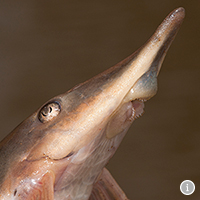

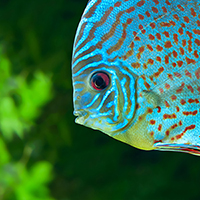

In [21]:
index = 7
sampleProb = (problems[str(index)])
print(get_question_text(sampleProb) + "\n")
print()
path = '/content/cs182final_proj/mm-cot/image_vals/' + str(index) + '_'
#NOTE: The image choice number (ie. choice 0 and choice 1) do NOT correspond to
# choice A, choice B (for instance, in this example, A is the discus,
#B is the armored catfish, but the discus image is labeled choice_1, the armored
# catfish image is labeled choice_0).
#This is an artifact of the ScienceQA dataset. For our purposes, this won't
#impact things, as we are simply showing the images to help build intuition.
#In this notebook, we will be using the vision features that have already been
# extracted from the images, and so won't be using the raw image data.
if os.path.isfile(path + 'choice_0.png'):
  display(Image(path + 'choice_0.png'))
print("\n")
if os.path.isfile(path + 'choice_1.png'):
  display(Image(path + 'choice_1.png'))

In [22]:
# For context, here is the answer that you should have gotten.
# Is it easier to get to this answer now that you've seen the image?
print(get_answer(sampleProb, args.options))
print(get_origin_answer(sampleProb, args.options))

B
armored catfish


# (c) Dataloading



In [23]:
#@title Set arguments (for rationale generation later)
args.model  = "allenai/unifiedqa-t5-small"
args.user_msg = "rationale"
args.img_type = "detr"
args.bs = 1
args.eval_bs = 1
args.eval_acc = 10
args.output_len = 512
args.final_eval = True
args.prompt_format = "QCM-LE"
args_rationale = copy.deepcopy(args)

In [24]:
from torch.utils.data import Dataset

In [25]:
#@title Setup for dataset
import os
import json
import numpy as np
import torch
from utils_prompt import *

img_shape = {
    "resnet": (512, 2048),
    "clip": (49, 2048),
    "detr": (100, 256),
}

def load_data_std(args):
    problems = json.load(open(os.path.join(args.data_root, 'scienceqa/problems.json')))
    pid_splits = json.load(open(os.path.join(args.data_root, 'scienceqa/pid_splits.json')))
    captions = json.load(open(args.caption_file))["captions"]

    for qid in problems:
        problems[qid]['caption'] = captions[qid] if qid in captions else ""

    train_qids = pid_splits['%s' % (args.train_split)]
    val_qids = pid_splits['%s' % (args.val_split)]
    test_qids = pid_splits['%s' % (args.test_split)]
    print(f"number of train problems: {len(train_qids)}\n")
    print(f"number of val problems: {len(val_qids)}\n")
    print(f"number of test problems: {len(test_qids)}\n")

    qids = {'train': train_qids, 'val':val_qids,'test':test_qids}
    return problems, qids,

def load_data_img(args):
    problems = json.load(open(os.path.join(args.data_root, 'scienceqa/problems.json')))
    pid_splits = json.load(open(os.path.join(args.data_root, 'scienceqa/pid_splits.json')))
    captions = json.load(open(args.caption_file))["captions"]
    name_maps = json.load(open('vision_features/name_map.json'))

    # check
    if args.img_type == "resnet":
        image_features = np.load('vision_features/resnet.npy')
        image_features = np.expand_dims(image_features, axis=1)
        image_features = image_features.repeat(512, axis=1)
    elif args.img_type == "clip":
        image_features = np.load('vision_features/clip.npy')
    elif args.img_type == "detr":
        image_features = np.load('vision_features/detr.npy')
    else:
        image_features = np.load('vision_features/detr.npy')
    print("img_features size: ", image_features.shape)

    for qid in problems:
        problems[qid]['caption'] = captions[qid] if qid in captions else ""

    train_qids = pid_splits['%s' % (args.train_split)]
    val_qids = pid_splits['%s' % (args.val_split)]
    test_qids = pid_splits['%s' % (args.test_split)]
    print(f"number of train problems: {len(train_qids)}\n")
    print(f"number of val problems: {len(val_qids)}\n")
    print(f"number of test problems: {len(test_qids)}\n")

    qids = {'train': train_qids, 'val':val_qids,'test':test_qids}
    return problems, qids, name_maps, image_features

class ScienceQADatasetStd(Dataset):
    """
    Creating a custom dataset for reading the dataset and
    loading it into the dataloader to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, problems, qids, tokenizer, source_len, target_len, args, test_le=None
    ):
        self.tokenizer = tokenizer
        self.data = {qid : problems[qid] for qid in qids}
        self.source_len = source_len
        self.summ_len = target_len
        self.target_text = []
        self.source_text = []
        if test_le is not None:
            test_le_data =json.load(open(test_le))["preds"]
        else:
            test_le_data = None
        idx = 0
        for qid in self.data:
            if test_le_data is not None:
                curr_le_data = test_le_data[idx]
                idx += 1
            else:
                curr_le_data = None
            prompt, target = build_train_pair(problems, qid, args, curr_le_data)
            self.target_text.append(target)
            self.source_text.append(prompt)

    def __len__(self):
        return len(self.target_text)

    def __getitem__(self, index):
        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze().tolist()

        return {
            "input_ids": source_ids,
            "attention_mask": source_mask,
            "labels": target_ids,
        }

In [26]:
#@title Load data and image features
# training logger to log training progress
training_logger = Table(
    Column("Epoch", justify="center"),
    Column("Steps", justify="center"),
    Column("Loss", justify="center"),
    title="Training Status",
    pad_edge=False,
    box=box.ASCII,
)

#args = parse_args()
print("args",args)
print('====Input Arguments====')
print(json.dumps(vars(args), indent=2, sort_keys=False))

random.seed(args.seed)

if not os.path.exists(args.output_dir):
        os.mkdir(args.output_dir)

if args.img_type is not None:
    problems, qids, name_maps, image_features = load_data_img(args)  # problems, test question ids, shot example ids
    dataframe = {'problems':problems, 'qids':qids, 'name_maps': name_maps, 'image_features': image_features}
else:
    problems, qids = load_data_std(args)  # problems, test question ids, shot example ids
    dataframe = {'problems':problems, 'qids':qids}

args Namespace(f='/root/.local/share/jupyter/runtime/kernel-b9487286-151d-4f20-bcae-6125d6485aba.json', data_root='data', output_dir='experiments', model='allenai/unifiedqa-t5-small', options=['A', 'B', 'C', 'D', 'E'], epoch=1, lr=5e-05, bs=1, input_len=512, output_len=512, eval_bs=1, eval_acc=10, train_split='minitrain', val_split='minival', test_split='minitest', use_generate=False, final_eval=True, user_msg='rationale', img_type='detr', eval_le=None, test_le=None, evaluate_dir=None, caption_file='data/captions.json', use_caption=False, prompt_format='QCM-LE', seed=42)
====Input Arguments====
{
  "f": "/root/.local/share/jupyter/runtime/kernel-b9487286-151d-4f20-bcae-6125d6485aba.json",
  "data_root": "data",
  "output_dir": "experiments",
  "model": "allenai/unifiedqa-t5-small",
  "options": [
    "A",
    "B",
    "C",
    "D",
    "E"
  ],
  "epoch": 1,
  "lr": 5e-05,
  "bs": 1,
  "input_len": 512,
  "output_len": 512,
  "eval_bs": 1,
  "eval_acc": 10,
  "train_split": "minitrain"

In [27]:
#@title Split qids
torch.manual_seed(args.seed)  # pytorch random seed
np.random.seed(args.seed)  # numpy random seed
torch.backends.cudnn.deterministic = True

if args.evaluate_dir is not None:
    args.model = args.evaluate_dir

tokenizer = T5Tokenizer.from_pretrained(args.model)

console.log(f"""[Model]: Loading {args.model}...\n""")
console.log(f"[Data]: Reading data...\n")
problems = dataframe['problems']
qids = dataframe['qids']
train_qids = qids['train']
test_qids = qids['test']
val_qids = qids['val']

if args.evaluate_dir is not None:
    save_dir = args.evaluate_dir
else:
    model_name = args.model.replace("/","-")
    gpu_count = torch.cuda.device_count()
    save_dir = f"{args.output_dir}/{args.user_msg}_{model_name}_{args.img_type}_{args.prompt_format}_lr{args.lr}_bs{args.bs * gpu_count}_op{args.output_len}_ep{args.epoch}"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

padding_idx = tokenizer._convert_token_to_id(tokenizer.pad_token)

[06:24:27] [Model]: Loading allenai/unifiedqa-t5-small...                        <ipython-input-27-fb63a6d0084c>:11
                                                                                                                   

           [Data]: Reading data...                                               <ipython-input-27-fb63a6d0084c>:12
                                                                                                                   

# c) Dataloading
### CODING PART BELOW
Dataloading typically involves reading data from one or more sources, such as a file or a database, and performing preprocessing steps such as normalization, transformation, or augmentation, in order to prepare the data for use in the model.This process determines how efficiently and effectively the model can learn from the data.


i. Implement the following part.

Initialize and tokenize the prompt and the target.

Run the “Dataloader Test” code cell to check your answer.

*Hint: to initialize the prompt and the target, use the given prompt building utils.*


In [28]:
class ScienceQADatasetImg(Dataset):
    """
    Creating a custom dataset for reading the dataset and
    loading it into the dataloader to pass it to the
    neural network for finetuning the model
    """

    def __init__(
        self, problems, qids, name_maps, tokenizer, source_len, target_len, args, image_features, test_le=None
    ):
        """
        Initializes a Dataset class
        Args:
            dataframe (pandas.DataFrame): Input dataframe
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = {qid : problems[qid] for qid in qids}
        self.source_len = source_len
        self.summ_len = target_len
        self.target_text = []
        self.source_text = []
        self.image_ids = []
        if test_le is not None:
            test_le_data =json.load(open(test_le))["preds"]
        else:
            test_le_data = None
        idx = 0
        for qid in self.data:
            if test_le_data is not None:
                curr_le_data = test_le_data[idx]
                idx += 1
            else:
                curr_le_data = None


            ### TO DO ###

            ### HINT: Look at utils_prompt.py ###

            ###HINT: Note that you want to be building the target and the prompt###
            prompt, target = build_train_pair(problems, qid, args, curr_le_data)
            self.target_text.append(target)
            self.source_text.append(prompt)
            #############
            if str(qid) in name_maps:
                i_vectors = image_features[int(name_maps[str(qid)])]
                self.image_ids.append(i_vectors)
            else:
                shape = img_shape[args.img_type]
                self.image_ids.append(np.zeros(shape))

    def __len__(self):
        """returns the length of dataframe"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])
        image_ids = self.image_ids[index]

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        ### TO DO: Implement tokenizer. Documentation here:
        ### https://huggingface.co/transformers/v2.11.0/main_classes/tokenizer.html
        ### HINT: You'll want to tokenize batches
        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        #############
        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze().tolist()

        image_ids = torch.tensor(image_ids).squeeze()

        return {
            "input_ids": source_ids,
            "attention_mask": source_mask,
            "image_ids": image_ids,
            "labels": target_ids,
        }

# Test whether your data loader works

In [29]:
#@title Create Dataloader
patch_size = img_shape[args.img_type]
#model = T5ForMultimodalGeneration.from_pretrained(args.model, patch_size=patch_size, padding_idx=padding_idx, save_dir=save_dir)
name_maps = dataframe['name_maps']
image_features = dataframe['image_features']
train_set = ScienceQADatasetImg(
    problems,
    train_qids,
    name_maps,
    tokenizer,
    args.input_len,
    args.output_len,
    args,
    image_features,
)
eval_set = ScienceQADatasetImg(
    problems,
    val_qids[:20],
    name_maps,
    tokenizer,
    args.input_len,
    args.output_len,
    args,
    image_features,
    args.eval_le,
)
test_set = ScienceQADatasetImg(
    problems,
    test_qids[:20],
    name_maps,
    tokenizer,
    args.input_len,
    args.output_len,
    args,
    image_features,
    args.test_le,
)

In [30]:
#@title Test Dataloader
# test train set
expected_input_ids = np.array([11860,    10,  4073,    13,   175,  2315,    19,   623,   189,   222,
         3414,    58,  1193,  6327,    10,   445,    87,   188, 17011,    10,
           41,   188,    61,  1013,  5089,    41,   279,    61, 17903,  2834,
           41,   254,    61, 10585,    41,   308,    61, 13782, 17942,    10,
            1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
assert np.allclose(np.array(train_set[7]['input_ids']), expected_input_ids)


# d) Model architecture

i. The two-stage framework takes the input (text and image), generates rationale, and then appends the rationale to the original input to create a modified input. This modified input is then passed into the second model, the inference model. What architectural structure (covered in the course) is this reminiscent of or analogous to?

ii. Refer to the Homework PDF for information on the model architecture.

In [31]:
#@title Metrics
def extract_ans(ans):
    pattern = re.compile(r'The answer is \(([A-Z])\)')
    res = pattern.findall(ans)

    if len(res) == 1:
        answer = res[0]  # 'A', 'B', ...
    else:
        answer = "FAILED"
    return answer

# accuracy for answer inference
def compute_metrics_acc(eval_preds):
    if args.use_generate:
        preds, targets = eval_preds
        if isinstance(preds, tuple):
            preds = preds[0]
    else:
        preds = eval_preds.predictions[0]
        targets = eval_preds.label_ids
        preds = preds.argmax(axis=2)
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    targets = tokenizer.batch_decode(targets, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    correct = 0
    assert len(preds) == len(targets)
    for idx, pred in enumerate(preds):
        reference = targets[idx]
        reference = extract_ans(reference)
        extract_pred = extract_ans(pred)
        best_option = extract_pred
        if reference == best_option:
            correct +=1
    return {'accuracy': 1.0*correct/len(targets)}

# rougel for rationale generation
metric = evaluate.load("rouge")
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]
    return preds, labels

def compute_metrics_rougel(eval_preds):
    if args.use_generate:
        preds, targets = eval_preds
        if isinstance(preds, tuple):
            preds = preds[0]
    else:
        preds = eval_preds.predictions[0]
        targets = eval_preds.label_ids
        preds = preds.argmax(axis=2)
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    targets = tokenizer.batch_decode(targets, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    decoded_preds, decoded_labels = postprocess_text(preds, targets)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result

# Model building here
### CODING PART HERE (implement the TODO sections). Refer to the PDF.

In [32]:
# @title Model Class (TODO)
from transformers import T5Config, T5ForConditionalGeneration
from transformers.models.t5.modeling_t5 import T5Stack, __HEAD_MASK_WARNING_MSG, T5EncoderModel
import copy
import math
import os
import warnings
from typing import Optional, Tuple, Union
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from transformers.modeling_outputs import (
    BaseModelOutput,
    Seq2SeqLMOutput,
)

class T5ForMultimodalGeneration(T5ForConditionalGeneration):
    _keys_to_ignore_on_load_missing = [
        r"encoder.embed_tokens.weight",
        r"decoder.embed_tokens.weight",
        r"lm_head.weight",
    ]
    _keys_to_ignore_on_load_unexpected = [
        r"decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight",
    ]

    def __init__(self, config: T5Config, patch_size, padding_idx, save_dir):
        super().__init__(config)
        self.model_dim = config.d_model

        self.padding_idx = padding_idx
        self.out = open(os.path.join(save_dir, 'gate.txt'), 'w')


        ## TODO IMPLEMENT MODEL HERE
        # HINT START WITH EMBEDDING
        self.shared = nn.Embedding(config.vocab_size, config.d_model)
        self.patch_num, self.patch_dim = patch_size

        self.image_dense = nn.Linear(self.patch_dim, config.d_model)
        self.mha_layer = torch.nn.MultiheadAttention(embed_dim=config.hidden_size, kdim=config.hidden_size, vdim=config.hidden_size, num_heads=1, batch_first=True)
        self.gate_dense = nn.Linear(2*config.hidden_size, config.hidden_size)
        self.sigmoid = nn.Sigmoid()
        ########################

        ## comment the encoder and decoder
        encoder_config = copy.deepcopy(config)
        encoder_config.is_decoder = False
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False

        ## TODO: Impelement encoder. Hint:  use t5stack
        #T5stack uses a stack of T5 encoders and decoders to improve
        #performance on tasks that require multi-step reasoning and inference.
        #The input text is first processed by a stack of T5 encoders,
        #which encode the input text into a series of feature vectors that capture its meaning and context.
        #The encoded features are then passed through a stack of T5 decoders,
        #which generate the output text by predicting the next token in the sequence at each step.
        self.encoder = T5Stack(encoder_config, self.shared)
        ####################################

        decoder_config = copy.deepcopy(config)
        decoder_config.is_decoder = True
        decoder_config.is_encoder_decoder = False
        decoder_config.num_layers = config.num_decoder_layers
        ################################

        ## TODO: Impelement decoder. Hint:  use t5stack
        self.decoder = T5Stack(decoder_config, self.shared)
        ############################

        ## TODO: implement the lm_head layer
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)

        ######################################################

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        image_ids=None,
        attention_mask: Optional[torch.FloatTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.BoolTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        decoder_head_mask: Optional[torch.FloatTensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.FloatTensor], Seq2SeqLMOutput]:
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # FutureWarning: head_mask was separated into two input args - head_mask, decoder_head_mask
        if head_mask is not None and decoder_head_mask is None:
            if self.config.num_layers == self.config.num_decoder_layers:
                warnings.warn(__HEAD_MASK_WARNING_MSG, FutureWarning)
                decoder_head_mask = head_mask

        # Encode if needed (training, first prediction pass)
        if encoder_outputs is None:
            # Convert encoder inputs in embeddings if needed
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                inputs_embeds=inputs_embeds,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )

        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        hidden_states = encoder_outputs[0]


        ## TODO IMPLEMENT THE FORWARD FUNCTION
        image_embedding = self.image_dense(image_ids)
        image_att, _ = self.mha_layer(hidden_states, image_embedding, image_embedding)

        merge = torch.cat([hidden_states, image_att], dim=-1)
        gate = self.sigmoid(self.gate_dense(merge))
        hidden_states = (1 - gate) * hidden_states + gate * image_att
        ############################################

        if labels is not None and decoder_input_ids is None and decoder_inputs_embeds is None:
            # get decoder inputs from shifting lm labels to the right
            decoder_input_ids = self._shift_right(labels)


        # Decode
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            inputs_embeds=decoder_inputs_embeds,
            past_key_values=past_key_values,
            encoder_hidden_states=hidden_states,
            encoder_attention_mask=attention_mask,
            head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = decoder_outputs[0]

        if self.config.tie_word_embeddings:
            # Rescale output before projecting on vocab
            # See https://github.com/tensorflow/mesh/blob/fa19d69eafc9a482aff0b59ddd96b025c0cb207d/mesh_tensorflow/transformer/transformer.py#L586
            sequence_output = sequence_output * (self.model_dim**-0.5)

        lm_logits = self.lm_head(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))

        if not return_dict:
            output = (lm_logits,) + decoder_outputs[1:] + encoder_outputs
            return ((loss,) + output) if loss is not None else output

        return Seq2SeqLMOutput(
            loss=loss,
            logits=lm_logits,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )

##Load Model##

In [33]:
model_untrained_rat = T5ForMultimodalGeneration.from_pretrained(args.model, patch_size=patch_size, padding_idx=padding_idx, save_dir=save_dir)
model_pretrained_rat = T5ForMultimodalGeneration.from_pretrained('/content/cs182final_proj/mm-cot/experiments/rationale_allenai-unifiedqa-t5-small_detr_QCM-LE_lr5e-05_bs32_op512_ep20/', patch_size=patch_size, padding_idx=padding_idx, save_dir=save_dir)

print("model parameters: ", model_untrained_rat.num_parameters())


Some weights of T5ForMultimodalGeneration were not initialized from the model checkpoint at allenai/unifiedqa-t5-small and are newly initialized: ['gate_dense.bias', 'mha_layer.in_proj_bias', 'gate_dense.weight', 'mha_layer.out_proj.weight', 'image_dense.weight', 'image_dense.bias', 'mha_layer.in_proj_weight', 'mha_layer.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model parameters:  62213632


In [34]:
# only use the last model for evaluation to save time
datacollator = DataCollatorForSeq2Seq(tokenizer)
if args.final_eval:
    training_args = Seq2SeqTrainingArguments(
        save_dir,
        do_train=True if args.evaluate_dir is None else False,
        do_eval=False,
        evaluation_strategy="no",
        logging_strategy="steps",
        save_strategy="epoch",
        save_total_limit = 0,
        learning_rate= args.lr,
        eval_accumulation_steps=args.eval_acc,
        per_device_train_batch_size=args.bs,
        per_device_eval_batch_size=args.eval_bs,
        weight_decay=0.01,
        num_train_epochs=args.epoch,
        predict_with_generate=args.use_generate,
        report_to="none",
    )
# evaluate at each epoch
else:
    training_args = Seq2SeqTrainingArguments(
        save_dir,
        do_train=True if args.evaluate_dir is None else False,
        do_eval=True,
        evaluation_strategy="epoch",
        logging_strategy="steps",
        save_strategy="epoch",
        save_total_limit = 0,
        learning_rate= args.lr,
        eval_accumulation_steps=args.eval_acc,
        per_device_train_batch_size=args.bs,
        per_device_eval_batch_size=args.eval_bs,
        weight_decay=0.01,
        num_train_epochs=args.epoch,
        metric_for_best_model="accuracy" if args.prompt_format != "QCM-LE" else "rougeL",
        predict_with_generate=args.use_generate,
        load_best_model_at_end=True,
        report_to="none",
    )

example_trainer_rationale = Seq2SeqTrainer(
    model=model_untrained_rat,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=eval_set,
    data_collator=datacollator,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics_acc if args.prompt_format != "QCM-LE" else compute_metrics_rougel
)

actual_trainer_rationale = Seq2SeqTrainer(
    model=model_pretrained_rat,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=eval_set,
    data_collator=datacollator,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics_acc if args.prompt_format != "QCM-LE" else compute_metrics_rougel
)

# (e) Visualization of rationales on examples

In the following blocks, the model has not been trained yet. However, we will show what the model currently predicts with the random intialized weights (rationale generation model with no training).

In [35]:
# Choose whatever question ids you want to use
example_qids = ['2'];

In [36]:
example_set = ScienceQADatasetImg(
    problems,
    example_qids,
    name_maps,
    tokenizer,
    args.input_len,
    args.output_len,
    args,
    image_features,
    args.test_le,
)
predict_results = example_trainer_rationale.predict(test_dataset=example_set, max_length=args.output_len)


***** Running Prediction *****
  Num examples = 1
  Batch size = 1


In [37]:
def decode_pred(pred):
  if args.use_generate:
      preds, targets = pred.predictions, pred.label_ids
  else:
      preds = pred.predictions[0]
      targets = pred.label_ids
      preds = preds.argmax(axis=2)

  preds = tokenizer.batch_decode(
      preds, skip_special_tokens=True, clean_up_tokenization_spaces=True
  )
  targets = tokenizer.batch_decode(
      targets, skip_special_tokens=True, clean_up_tokenization_spaces=True
  )
  return preds, targets

preds, targets = decode_pred(predict_results)


In [38]:
f"Untrained Prediction: {preds[0]}"

'Untrained Prediction: : ence  be  to  the  you you  the channels  youa  channel  be the to  the, you will to be out how you the on the   afterwards the,e      a   aa., of    to the.  then    in the..n, you  of the    inn, the the channels you the channels and you followed onn .   a  a  a  a'

In [39]:
targets[0]

'Solution: Experiments can be designed to answer specific questions. How can you identify the questions that a certain experiment can answer? In order to do this, you need to figure out what was tested and what was measured during the experiment.nImagine an experiment with two groups of daffodil plants. One group of plants was grown in sandy soil, and the other was grown in clay soil. Then, the height of each plant was measured.nFirst, identify the part of the experiment that was tested. The part of an experiment that is tested usually involves the part of the experimental setup that is different or changed. In the experiment described above, each group of plants was grown in a different type of soil. So, the effect of growing plants in different soil types was tested.nThen, identify the part of the experiment that was measured. The part of the experiment that is measured may include measurements and calculations. In the experiment described above, the heights of the plants in each gro

i. What pattern do you see in the rationales generated from the model that hasn’t been trained yet? Why do you think this pattern exists?


# Now we will actually train the model. Run the following training cells. This model is loaded with pretrained weights and you will finish running the last two epochs of the model. This should take about 5 minutes.


In [40]:
#@title training
if args.evaluate_dir is None:
    actual_trainer_rationale.train()
    actual_trainer_rationale.save_model(save_dir)
metrics = actual_trainer_rationale.evaluate(eval_dataset = test_set)
actual_trainer_rationale.log_metrics("test", metrics)
predict_results = actual_trainer_rationale.predict(test_dataset=test_set, max_length=args.output_len)

***** Running training *****
  Num examples = 1272
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 1272


Step,Training Loss
500,0.280100
1000,0.317700


Saving model checkpoint to experiments/rationale_allenai-unifiedqa-t5-small_detr_QCM-LE_lr5e-05_bs1_op512_ep1/checkpoint-1272
Configuration saved in experiments/rationale_allenai-unifiedqa-t5-small_detr_QCM-LE_lr5e-05_bs1_op512_ep1/checkpoint-1272/config.json
Model weights saved in experiments/rationale_allenai-unifiedqa-t5-small_detr_QCM-LE_lr5e-05_bs1_op512_ep1/checkpoint-1272/pytorch_model.bin
tokenizer config file saved in experiments/rationale_allenai-unifiedqa-t5-small_detr_QCM-LE_lr5e-05_bs1_op512_ep1/checkpoint-1272/tokenizer_config.json
Special tokens file saved in experiments/rationale_allenai-unifiedqa-t5-small_detr_QCM-LE_lr5e-05_bs1_op512_ep1/checkpoint-1272/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to experiments/rationale_allenai-unifiedqa-t5-small_detr_QCM-LE_lr5e-05_bs1_op512_ep1
Configuration saved in experiments/rationale_allenai-unifiedqa-t5-small_detr_QCM-LE_lr5e-05_bs1_op51

***** Running Prediction *****
  Num examples = 20
  Batch size = 1


***** test metrics *****
  epoch                   =        1.0
  eval_gen_len            =        1.0
  eval_loss               =     0.1356
  eval_rouge1             =    91.8846
  eval_rouge2             =    83.8336
  eval_rougeL             =    90.5775
  eval_rougeLsum          =    91.9052
  eval_runtime            = 0:00:16.59
  eval_samples_per_second =      1.205
  eval_steps_per_second   =      1.205


In [41]:
actual_result = actual_trainer_rationale.predict(test_dataset=example_set, max_length=args.output_len)

***** Running Prediction *****
  Num examples = 1
  Batch size = 1


Trained Rational Inference

In [42]:
actual_pred, actual_target = decode_pred(actual_result)
actual_pred[0]

'Solution: Experiments can be designed to answer specific questions. How can you identify the questions that a certain experiment can answer? In order to do this, you need to figure out what was tested and what was measured during the experiment.nImagine an experiment with two groups of daffodil plants. One group of plants was grown in sandy soil, and the other was grown in clay soil. Then, the height of each plant was measured.nFirst, identify the part of the experiment that was tested. The part of an experiment that is tested usually involves the part of the experimental setup that is different or changed. In the experiment described above, each group of plants was grown in a different type of soil. So, the effect of growing plants in different soil types was tested.nThen, identify the part of the experiment that was measured. The part of the experiment that is measured may include measurements and calculations. In the experiment described above, the heights of the plants in each gro

In [43]:
actual_target[0]

'Solution: Experiments can be designed to answer specific questions. How can you identify the questions that a certain experiment can answer? In order to do this, you need to figure out what was tested and what was measured during the experiment.nImagine an experiment with two groups of daffodil plants. One group of plants was grown in sandy soil, and the other was grown in clay soil. Then, the height of each plant was measured.nFirst, identify the part of the experiment that was tested. The part of an experiment that is tested usually involves the part of the experimental setup that is different or changed. In the experiment described above, each group of plants was grown in a different type of soil. So, the effect of growing plants in different soil types was tested.nThen, identify the part of the experiment that was measured. The part of the experiment that is measured may include measurements and calculations. In the experiment described above, the heights of the plants in each gro

#Answer Inference

In [44]:
#@title Set arguments for answer inference
args = parse_args()
args.model  = "allenai/unifiedqa-t5-base"
args.user_msg = "answer"
args.img_type = "detr"
args.bs = 1
args.eval_bs = 1
args.eval_acc = 10
args.output_len = 64
args.final_eval = True
args.prompt_format = "QCMG-A"
# Change this
args.eval_le = "predictions_ans_eval.json"
args.test_le = "predictions_ans_test.json"
args_answer = copy.deepcopy(args)

In [45]:
#@title Load data and image features for answer inference
# training logger to log training progress
training_logger = Table(
    Column("Epoch", justify="center"),
    Column("Steps", justify="center"),
    Column("Loss", justify="center"),
    title="Training Status",
    pad_edge=False,
    box=box.ASCII,
)

#args = parse_args()
print("args",args)
print('====Input Arguments====')
print(json.dumps(vars(args), indent=2, sort_keys=False))

random.seed(args.seed)

if not os.path.exists(args.output_dir):
        os.mkdir(args.output_dir)

if args.img_type is not None:
    problems, qids, name_maps, image_features = load_data_img(args)  # problems, test question ids, shot example ids
    dataframe = {'problems':problems, 'qids':qids, 'name_maps': name_maps, 'image_features': image_features}
else:
    problems, qids = load_data_std(args)  # problems, test question ids, shot example ids
    dataframe = {'problems':problems, 'qids':qids}

args Namespace(f='/root/.local/share/jupyter/runtime/kernel-b9487286-151d-4f20-bcae-6125d6485aba.json', data_root='data', output_dir='experiments', model='allenai/unifiedqa-t5-base', options=['A', 'B', 'C', 'D', 'E'], epoch=1, lr=5e-05, bs=1, input_len=512, output_len=64, eval_bs=1, eval_acc=10, train_split='minitrain', val_split='minival', test_split='minitest', use_generate=False, final_eval=True, user_msg='answer', img_type='detr', eval_le='predictions_ans_eval.json', test_le='predictions_ans_test.json', evaluate_dir=None, caption_file='data/captions.json', use_caption=False, prompt_format='QCMG-A', seed=42)
====Input Arguments====
{
  "f": "/root/.local/share/jupyter/runtime/kernel-b9487286-151d-4f20-bcae-6125d6485aba.json",
  "data_root": "data",
  "output_dir": "experiments",
  "model": "allenai/unifiedqa-t5-base",
  "options": [
    "A",
    "B",
    "C",
    "D",
    "E"
  ],
  "epoch": 1,
  "lr": 5e-05,
  "bs": 1,
  "input_len": 512,
  "output_len": 64,
  "eval_bs": 1,
  "eval

In [46]:
#@title Split qids for answer inference
torch.manual_seed(args.seed)  # pytorch random seed
np.random.seed(args.seed)  # numpy random seed
torch.backends.cudnn.deterministic = True

if args.evaluate_dir is not None:
    args.model = args.evaluate_dir

tokenizer = T5Tokenizer.from_pretrained(args.model)

console.log(f"""[Model]: Loading {args.model}...\n""")
console.log(f"[Data]: Reading data...\n")
problems = dataframe['problems']
qids = dataframe['qids']
train_qids = qids['train']
test_qids = qids['test']
val_qids = qids['val']

if args.evaluate_dir is not None:
    save_dir = args.evaluate_dir
else:
    model_name = args.model.replace("/","-")
    gpu_count = torch.cuda.device_count()
    save_dir = f"{args.output_dir}/{args.user_msg}_{model_name}_{args.img_type}_{args.prompt_format}_lr{args.lr}_bs{args.bs * gpu_count}_op{args.output_len}_ep{args.epoch}"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

padding_idx = tokenizer._convert_token_to_id(tokenizer.pad_token)

https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/spiece.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpj_qx4x_2


storing https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/spiece.model in cache at /root/.cache/huggingface/transformers/362f2e256dbb3e562a891c34cf7e06cee6a3ddf83c41d1e72e4ee382a5eafe0b.3b69006860e7b5d0a63ffdddc01ddcd6b7c318a6f4fd793596552c741734c62d
creating metadata file for /root/.cache/huggingface/transformers/362f2e256dbb3e562a891c34cf7e06cee6a3ddf83c41d1e72e4ee382a5eafe0b.3b69006860e7b5d0a63ffdddc01ddcd6b7c318a6f4fd793596552c741734c62d
https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp0x8t8zif


storing https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/6de9d1094f721d3aa84e0b73e86256cd631e809641d8e864fd1ec11a261ba2de.c94798918c92ded6aeef2d2f0e666d2cc4145eca1aa6e1336fde07f2e13e2f46
creating metadata file for /root/.cache/huggingface/transformers/6de9d1094f721d3aa84e0b73e86256cd631e809641d8e864fd1ec11a261ba2de.c94798918c92ded6aeef2d2f0e666d2cc4145eca1aa6e1336fde07f2e13e2f46
https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpqwhdqlbe


storing https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/9354956bf33ef7faeb20dd166d3634a6eccca5665fa4324746923bb154fd7ec9.024cc07195c0ba0b51d4f80061c6115996ff26233f3d04788855b23cdf13fbd5
creating metadata file for /root/.cache/huggingface/transformers/9354956bf33ef7faeb20dd166d3634a6eccca5665fa4324746923bb154fd7ec9.024cc07195c0ba0b51d4f80061c6115996ff26233f3d04788855b23cdf13fbd5
loading file https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/spiece.model from cache at /root/.cache/huggingface/transformers/362f2e256dbb3e562a891c34cf7e06cee6a3ddf83c41d1e72e4ee382a5eafe0b.3b69006860e7b5d0a63ffdddc01ddcd6b7c318a6f4fd793596552c741734c62d
loading file https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/

storing https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/0e43bc47d08beb00ae62d12fb00e59bfd1ee0f5f6159e37f9089ce503ce6a88c.d6cfc093f102b024708562624bd2f4856f82be39369f65236ce8cb519d74d257
creating metadata file for /root/.cache/huggingface/transformers/0e43bc47d08beb00ae62d12fb00e59bfd1ee0f5f6159e37f9089ce503ce6a88c.d6cfc093f102b024708562624bd2f4856f82be39369f65236ce8cb519d74d257
loading configuration file https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/0e43bc47d08beb00ae62d12fb00e59bfd1ee0f5f6159e37f9089ce503ce6a88c.d6cfc093f102b024708562624bd2f4856f82be39369f65236ce8cb519d74d257
Model config T5Config {
  "_name_or_path": "allenai/unifiedqa-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
 

[06:28:45] [Model]: Loading allenai/unifiedqa-t5-base...                         <ipython-input-46-a4e15f65b4bb>:11
                                                                                                                   

           [Data]: Reading data...                                               <ipython-input-46-a4e15f65b4bb>:12
                                                                                                                   

In [47]:
#@title Create dataloader for answer inference
patch_size = img_shape[args.img_type]
#model = T5ForMultimodalGeneration.from_pretrained(args.model, patch_size=patch_size, padding_idx=padding_idx, save_dir=save_dir)
name_maps = dataframe['name_maps']
image_features = dataframe['image_features']
train_set = ScienceQADatasetImg(
    problems,
    train_qids,
    name_maps,
    tokenizer,
    args.input_len,
    args.output_len,
    args,
    image_features,
)
example_set = ScienceQADatasetImg(
    problems,
    example_qids,
    name_maps,
    tokenizer,
    args.input_len,
    args.output_len,
    args,
    image_features,
    args.test_le,
)

In [48]:
model_ans = T5ForMultimodalGeneration.from_pretrained(args.model, patch_size=patch_size, padding_idx=padding_idx, save_dir=save_dir)
pretrain_model_ans = T5ForMultimodalGeneration.from_pretrained('/content/cs182final_proj/mm-cot/experiments/answer_allenai-unifiedqa-t5-small_detr_QCMG-A_lr5e-05_bs32_op64_ep20', patch_size=patch_size, padding_idx=padding_idx, save_dir=save_dir)
print("model parameters: ", model_ans.num_parameters())

loading configuration file https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/0e43bc47d08beb00ae62d12fb00e59bfd1ee0f5f6159e37f9089ce503ce6a88c.d6cfc093f102b024708562624bd2f4856f82be39369f65236ce8cb519d74d257
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty

storing https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/f7299529a91c0abd61640e0dacaffc18e8efe8b64c23bd5a8481217305890617.377be89bb594a1fe4469e091907228ad9b1be181f7c2bc41c8e761f35bf8d094
creating metadata file for /root/.cache/huggingface/transformers/f7299529a91c0abd61640e0dacaffc18e8efe8b64c23bd5a8481217305890617.377be89bb594a1fe4469e091907228ad9b1be181f7c2bc41c8e761f35bf8d094
loading weights file https://huggingface.co/allenai/unifiedqa-t5-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f7299529a91c0abd61640e0dacaffc18e8efe8b64c23bd5a8481217305890617.377be89bb594a1fe4469e091907228ad9b1be181f7c2bc41c8e761f35bf8d094
All model checkpoint weights were used when initializing T5ForMultimodalGeneration.

Some weights of T5ForMultimodalGeneration were not initialized from the model checkpoint at allenai/unifiedqa-t5-base and are newly initialized: ['gate_dense.bias', 'mha

model parameters:  226643712


In [49]:
#@title Prepare trainer for answer inference
# only use the last model for evaluation to save time
datacollator = DataCollatorForSeq2Seq(tokenizer)
if args.final_eval:
    training_args = Seq2SeqTrainingArguments(
        save_dir,
        do_train=True if args.evaluate_dir is None else False,
        do_eval=False,
        evaluation_strategy="no",
        logging_strategy="steps",
        save_strategy="epoch",
        save_total_limit = 0,
        learning_rate= args.lr,
        eval_accumulation_steps=args.eval_acc,
        per_device_train_batch_size=args.bs,
        per_device_eval_batch_size=args.eval_bs,
        weight_decay=0.01,
        num_train_epochs=args.epoch,
        predict_with_generate=args.use_generate,
        report_to="none",
    )
# evaluate at each epoch
else:
    training_args = Seq2SeqTrainingArguments(
        save_dir,
        do_train=True if args.evaluate_dir is None else False,
        do_eval=True,
        evaluation_strategy="epoch",
        logging_strategy="steps",
        save_strategy="epoch",
        save_total_limit = 0,
        learning_rate= args.lr,
        eval_accumulation_steps=args.eval_acc,
        per_device_train_batch_size=args.bs,
        per_device_eval_batch_size=args.eval_bs,
        weight_decay=0.01,
        num_train_epochs=args.epoch,
        metric_for_best_model="accuracy" if args.prompt_format != "QCM-LE" else "rougeL",
        predict_with_generate=args.use_generate,
        load_best_model_at_end=True,
        report_to="none",
    )

trainer_ans = Seq2SeqTrainer(
    model=model_ans,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=eval_set,
    data_collator=datacollator,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics_acc if args.prompt_format != "QCM-LE" else compute_metrics_rougel
)

pretrain_trainer_ans = Seq2SeqTrainer(
    model=pretrain_model_ans,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=eval_set,
    data_collator=datacollator,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics_acc if args.prompt_format != "QCM-LE" else compute_metrics_rougel
)

PyTorch: setting up devices


**Answer Inference (inference only)**

In the following blocks, the model has not been trained yet. However, we will show what the model currently predicts with the random intialized weights (0 training answer inference).

In [50]:
predict_results = trainer_ans.predict(test_dataset=example_set, max_length=args.output_len)


***** Running Prediction *****
  Num examples = 1
  Batch size = 1


In [51]:
preds, targets = decode_pred(predict_results)


In [52]:
preds[0]

'is yesit)s'

In [53]:
targets[0]

'The answer is (B).'

In [54]:
args.epoch = 1

# Now the following cells will actually train the second model (answer inference)

In [55]:
# @title Training
if args.evaluate_dir is None:
    pretrain_trainer_ans.train()
    pretrain_trainer_ans.save_model(save_dir)

metrics = pretrain_trainer_ans.evaluate(eval_dataset = test_set)
pretrain_trainer_ans.log_metrics("test", metrics)
pretrain_trainer_ans.save_metrics("test", metrics)


***** Running training *****
  Num examples = 1272
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 1272


Step,Training Loss
500,0.002900
1000,0.002800


Saving model checkpoint to experiments/answer_allenai-unifiedqa-t5-base_detr_QCMG-A_lr5e-05_bs1_op64_ep1/checkpoint-1272
Configuration saved in experiments/answer_allenai-unifiedqa-t5-base_detr_QCMG-A_lr5e-05_bs1_op64_ep1/checkpoint-1272/config.json
Model weights saved in experiments/answer_allenai-unifiedqa-t5-base_detr_QCMG-A_lr5e-05_bs1_op64_ep1/checkpoint-1272/pytorch_model.bin
tokenizer config file saved in experiments/answer_allenai-unifiedqa-t5-base_detr_QCMG-A_lr5e-05_bs1_op64_ep1/checkpoint-1272/tokenizer_config.json
Special tokens file saved in experiments/answer_allenai-unifiedqa-t5-base_detr_QCMG-A_lr5e-05_bs1_op64_ep1/checkpoint-1272/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to experiments/answer_allenai-unifiedqa-t5-base_detr_QCMG-A_lr5e-05_bs1_op64_ep1
Configuration saved in experiments/answer_allenai-unifiedqa-t5-base_detr_QCMG-A_lr5e-05_bs1_op64_ep1/config.json
Model weights sav

***** test metrics *****
  epoch                   =        1.0
  eval_accuracy           =        1.0
  eval_loss               =     5.6533
  eval_runtime            = 0:00:14.92
  eval_samples_per_second =       1.34
  eval_steps_per_second   =       1.34


In [56]:
actual_result = pretrain_trainer_ans.predict(test_dataset=example_set, max_length=args.output_len)

preds, targets = decode_pred(actual_result)

preds[0]


***** Running Prediction *****
  Num examples = 1
  Batch size = 1


'The answer is (B).'

In [57]:
targets[0]

'The answer is (B).'

ii. With your now fully trained model, run inference on some data points! Do the rationales make sense? Do they help answer the question? Compare them to the rationales generated before the training.

Play around with the model by modifying the example_set to run inference on the different values in the dataset.

In [58]:
example_qids = ['4']
example_set_rationale = ScienceQADatasetImg(
    problems,
    example_qids,
    name_maps,
    tokenizer,
    args_rationale.input_len,
    args_rationale.output_len,
    args_rationale,
    image_features,
    args_rationale.test_le,
)

example_set_answer = ScienceQADatasetImg(
    problems,
    example_qids,
    name_maps,
    tokenizer,
    args_answer.input_len,
    args_answer.output_len,
    args_answer,
    image_features,
    args_answer.test_le,
)
rationale = actual_trainer_rationale.predict(test_dataset=example_set_rationale, max_length=args_rationale.output_len)
actual_result = pretrain_trainer_ans.predict(test_dataset=example_set_answer, max_length=args_answer.output_len)


***** Running Prediction *****
  Num examples = 1
  Batch size = 1


***** Running Prediction *****
  Num examples = 1
  Batch size = 1


In [66]:
actual_result

PredictionOutput(predictions=(array([[[-20.553139 , -13.6194725, -15.146949 , ..., -66.30806  ,
         -66.48955  , -66.43483  ],
        [-42.754436 , -21.816706 , -18.936804 , ..., -69.27102  ,
         -69.507164 , -69.40491  ],
        [-55.14881  , -23.498964 , -22.969002 , ..., -79.01204  ,
         -79.38814  , -79.019516 ],
        ...,
        [ 62.407757 ,   3.2617476,   8.441985 , ..., -17.190325 ,
         -17.116356 , -16.98977  ],
        [ 62.43513  ,   3.2727263,   8.476179 , ..., -17.178686 ,
         -17.103956 , -16.97731  ],
        [ 62.323555 ,   3.2674425,   8.435056 , ..., -17.346733 ,
         -17.26977  , -17.144165 ]]], dtype=float32), array([[[-0.052574  , -0.08742385,  0.28263894, ..., -0.17876793,
          0.00069275,  0.01282987],
        [ 0.27011722,  0.34516525,  0.0705001 , ...,  0.0785494 ,
          0.27232057,  0.14575216],
        [ 0.10507488,  0.12497596,  0.28435823, ..., -0.17625958,
          0.05009793,  0.02700367],
        ...,
        

In [59]:
example_set_rationale.data

{'4': {'question': 'Which figure of speech is used in this text?\nSing, O goddess, the anger of Achilles son of Peleus, that brought countless ills upon the Achaeans.\n—Homer, The Iliad',
  'choices': ['chiasmus', 'apostrophe'],
  'answer': 1,
  'hint': '',
  'image': None,
  'task': 'closed choice',
  'grade': 'grade11',
  'subject': 'language science',
  'topic': 'figurative-language',
  'category': 'Literary devices',
  'skill': 'Classify the figure of speech: anaphora, antithesis, apostrophe, assonance, chiasmus, understatement',
  'lecture': 'Figures of speech are words or phrases that use language in a nonliteral or unusual way. They can make writing more expressive.\nAnaphora is the repetition of the same word or words at the beginning of several phrases or clauses.\nWe are united. We are powerful. We are winners.\nAntithesis involves contrasting opposing ideas within a parallel grammatical structure.\nI want to help, not to hurt.\nApostrophe is a direct address to an absent per

In [60]:
preds_inference, targets_inference = decode_pred(actual_result)
preds_rationale, targets_rationale = decode_pred(rationale)

In [61]:
targets_rationale[0]

'Solution: Figures of speech are words or phrases that use language in a nonliteral or unusual way. They can make writing more expressive.nAnaphora is the repetition of the same word or words at the beginning of several phrases or clauses.nWe are united. We are powerful. We are winners.nAntithesis involves contrasting opposing ideas within a parallel grammatical structure.nI want to help, not to hurt.nApostrophe is a direct address to an absent person or a nonhuman entity.nOh, little bird, what makes you sing so beautifully?nAssonance is the repetition of a vowel sound in a series of nearby words.nTry to light the fire.nChiasmus is an expression in which the second half parallels the first but reverses the order of words.nNever let a fool kiss you or a kiss fool you.nUnderstatement involves deliberately representing something as less serious or important than it really is.nAs you know, it can get a little cold in the Antarctic. The text uses apostrophe, a direct address to an absent pe

In [62]:
preds_rationale[0]

'Solution: Figures of speech are words or phrases that use language in a nonliteral or unusual way. They can make writing more expressive.nA aphora is the repetition of the same word or words at the beginning of several phrases or clauses.nA are united. We are winners. We are winners.nAthesis involves contrasting opposing ideas within a parallel grammatical structure.nA want to help, not to hurt.nA trophe is a direct address to an absent person or a nonhuman entity.nA, little bird, what makes you sing so beautifully?nAssonance is the repetition of a vowel sound in a series of nearby words.nAry to light the fire.nAiasmus is an expression in which the second half parallels the first but reverses the order of words.nTheever let a fool kiss you or a kiss fool you.nAderstatement involves deliberately representing something as less serious or important than it really is.nAs you know, it can get a little cold in the Antarctic. text uses atrophe, a  address to an absent person or a particularh

In [64]:
preds_inference[0]

'The answer is (A).'

In [65]:
targets_inference[0]

'The answer is (B).'

# (f) Image robustness experimentation and visualization

Congratulations! You (hopefully) have a working multimodal CoT model! In this part of the assignment, you will explore the robustness of the multimodality of this model and see what happens when you feed incorrect data in.

i. Run part (f) of the notebook. In this part, you will experiment on a single example to better visualize and understand how the model you trained may or may not be robust to incorrect inputs. This first block simply displays the example discussed beforehand (the bottom feeder question), along with the text inputs and the image inputs.

In [67]:
import copy

our_name_maps = copy.deepcopy(name_maps)
our_name_maps['7'] = '32'

wrong_qids = ['4']
wrong_set_rationale = ScienceQADatasetImg(
    problems,
    ['7'],
    our_name_maps,
    tokenizer,
    args_rationale.input_len,
    args_rationale.output_len,
    args_rationale,
    image_features,
    args_rationale.test_le,
)

wrong_set_answer = ScienceQADatasetImg(
    problems,
    ['7'],
    our_name_maps,
    tokenizer,
    args_answer.input_len,
    args_answer.output_len,
    args_answer,
    image_features,
    args_answer.test_le,
)

rationale_wrong = actual_trainer_rationale.predict(test_dataset=wrong_set_rationale, max_length=args_rationale.output_len)
actual_result_wrong = pretrain_trainer_ans.predict(test_dataset=wrong_set_answer, max_length=args_answer.output_len)


***** Running Prediction *****
  Num examples = 1
  Batch size = 1


***** Running Prediction *****
  Num examples = 1
  Batch size = 1


### The following blocks of code will take a sample question that has an associated image attached to it, swap that image with another question's image, and then try running that question (in other words, the image attached into the model will be entirely unrelated to the question being asked by the prompt).

In [68]:
preds_inference_wrong, targets_inference_wrong = decode_pred(actual_result_wrong)
preds_rationale_wrong, targets_rationale_wrong, = decode_pred(rationale_wrong)

In [69]:
targets_rationale_wrong[0]

"Solution: An adaptation is an inherited trait that helps an organism survive or reproduce. Adaptations can include both body parts and behaviors.nThe shape of an animal's mouth is one example of an adaptation. Animals' mouths can be adapted in different ways. For example, a large mouth with sharp teeth might help an animal tear through meat. A long, thin mouth might help an animal catch insects that live in holes. Animals that eat similar food often have similar mouths. Look at the picture of the sturgeon.nThe sturgeon's mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding. The sturgeon uses its mouth to find food hidden in the sediment at the bottom of rivers, lakes, and the ocean.nNow look at each animal. Figure out which animal has a similar adaptation.nThe armored catfish's mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding.nThe discus's mouth is not located on the undersi

Which animal's mouth is also adapted for bottom feeding?




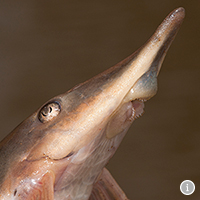

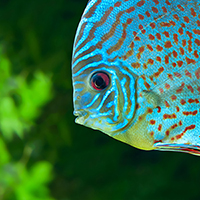

In [70]:
# The correct image to our problem
index = 7
sampleProb = (problems[str(index)])
print(get_question_text(sampleProb) + "\n")
print()
path = '/content/cs182final_proj/mm-cot/image_vals/' + str(index) + '_'

if os.path.isfile(path + 'choice_0.png'):
  display(Image(path + 'choice_0.png'))
print("\n")
if os.path.isfile(path + 'choice_1.png'):
  display(Image(path + 'choice_1.png'))

Which bird's beak is also adapted to tear through meat?




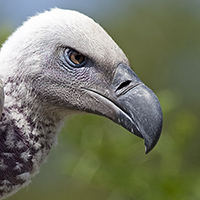

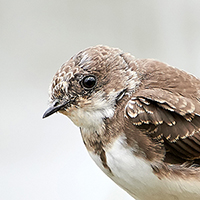

In [71]:
# The wrong image that we're putting in
index = 60
sampleProb = (problems[str(index)])
print(get_question_text(sampleProb) + "\n")
print()
path = '/content/cs182final_proj/mm-cot/image_vals/' + str(index) + '_'

if os.path.isfile(path + 'choice_0.png'):
  display(Image(path + 'choice_0.png'))
print("\n")
if os.path.isfile(path + 'choice_1.png'):
  display(Image(path + 'choice_1.png'))

In [72]:
targets_inference_wrong[0]

'The answer is (B).'

In [73]:
preds_rationale_wrong[0]

"Solution: An adaptation is an inherited trait that helps an organism survive or reproduce. Adaptations can include both body parts and behaviors.nThe shape of an animal's mouth is one example of an adaptation. Animals' mouths can be adapted in different ways. For example, a sharp mouth with sharp teeth might help an animal catch through fat easily A large, thin mouth might help an animal catch insects that live in water. Animals' liveeat similar food often have similar mouths. Look at the picture of the sturgeon.nNow armorsturgeon hass mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding. armorsturgeon uses its mouth to  food at in the ocean. the bottom of rivers, lakes, and the ocean.nThe look at each animal. Figure out which animal has a similar adaptation.nThe armored catfish hass mouth is not on the underside of its head and points downward. Its mouth is notadapted for bottom feeding..nThe discus hass mouth is not  on the under

In [74]:
preds_inference_wrong[0]

'The answer is (A).'

In [75]:
#@title This is the original prompt and target answer for the bottom feeder question. Is it the same as the cells run above?

index = 7

shot_qids = ['1', '10']
test_qid = str(index)

input, target = build_train_pair(problems, test_qid, args)
input

"Question: Which animal's mouth is also adapted for bottom feeding?\nContext: Sturgeons eat invertebrates, plants, and small fish. They are bottom feeders. Bottom feeders find their food at the bottom of rivers, lakes, and the ocean.\nThe 's mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding.\nFigure: sturgeon.\nOptions: (A) discus (B) armored catfish\nSolution: An adaptation is an inherited trait that helps an organism survive or reproduce. Adaptations can include both body parts and behaviors.\\nThe shape of an animal's mouth is one example of an adaptation. Animals' mouths can be adapted in different ways. For example, a large mouth with sharp teeth might help an animal tear through meat. A long, thin mouth might help an animal catch insects that live in holes. Animals that eat similar food often have similar mouths. Look at the picture of the sturgeon.\\nThe sturgeon's mouth is located on the underside of its head and points d

In [76]:
target

'The answer is (B).'

# What do you notice between the original inference (where the question has the correct image) versus the "wrong" inference (where the question has an incorrect image)? What does this suggest about this model's reliance on the image modality for performance? Write your answer in the text box below.

Write your answer here